In [17]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append("../src")

from utils.io import load_pickle
from utils.feature import load_feature

pd.set_option('display.max_rows', 5000)


%matplotlib inline

plt.style.use("seaborn-v0_8")

In [40]:
sys.path.append("../src")

誤差が大きいサンプルの特徴を知りたい

In [52]:
data = pd.read_csv("../data/preprocessed/train.csv")
oof_xgb = load_pickle("../data/model/xgb/seed=42/oof.pkl")


feature_names = [
    "word_count",
    "word_overlap_count",
    "text_length",
    "spell_miss_count",
    "sentence_count",
    "quotes_count",
    "quoted_sentence_count",
    "consecutive_dots_count",
]
features = load_feature("../data/feature", feature_names)
feat_df = pd.DataFrame(features, columns=feature_names)


data[["content_pred", "wording_pred"]] = oof_xgb
data = pd.concat([data, feat_df], axis=1)

In [53]:
data = data.assign(
    content_diff=lambda df: (df["content"] - df["content_pred"]).apply(np.square),
    wording_diff=lambda df: (df["wording"] - df["wording_pred"]).apply(np.square),
)

In [54]:
data.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,fold,content_pred,...,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count,content_diff,wording_diff
0,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,000e8c3c7ddb,The third wave was an experimentto see how peo...,0.205683,0.380538,3,0.195369,...,61,8,346,5,4,0,0,0,0.000106,0.105886
1,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",0020ae56ffbf,They would rub it up with soda to make the sme...,-0.548304,0.506755,2,-0.612499,...,52,8,244,2,3,0,0,0,0.004121,0.611893
2,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,004e978e639e,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1,2.782406,...,235,8,1370,32,13,2,2,0,0.120078,1.930234
3,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,005ab0199905,The highest class was Pharaohs these people we...,-0.210614,-0.471415,1,-1.100059,...,25,7,157,5,5,0,0,0,0.791112,0.276773
4,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0070c9e7af47,The Third Wave developed rapidly because the ...,3.272894,3.219757,3,2.792669,...,203,8,1225,30,14,4,4,0,0.230617,0.393090


In [55]:
data.groupby("prompt_id")[["content_diff", "wording_diff"]].agg(["mean", "size"])

content_diff       wording_diff      
                  mean  size         mean  size
prompt_id                                      
39c16e        0.148966  2057     0.291739  2057
3b9047        0.210776  2009     0.426378  2009
814d6b        0.212139  1103     0.413680  1103
ebad26        0.186954  1996     0.295167  1996

In [56]:
from metric import mcrmse, rmse


mcrmse(data[["content", "wording"]].to_numpy(), data[["content_pred", "wording_pred"]].to_numpy())

0.5114619018598424

In [61]:
for prompt_id, gdf in data.groupby("prompt_id"):
    print("prompt_id:", prompt_id)
    print("content:", rmse(gdf["content"].to_numpy(), gdf["content_pred"].to_numpy()))
    print("wording:", rmse(gdf["wording"].to_numpy(), gdf["wording_pred"].to_numpy()))
    print(mcrmse(gdf[["content", "wording"]].to_numpy(), gdf[["content_pred", "wording_pred"]].to_numpy()))
    print()

prompt_id: 39c16e
content: 0.3859605791503319
wording: 0.540128249549441
0.46304441434988647

prompt_id: 3b9047
content: 0.459103986973445
wording: 0.6529760159847903
0.5560400014791176

prompt_id: 814d6b
content: 0.46058592070420823
wording: 0.6431796966636583
0.5518828086839332

prompt_id: ebad26
content: 0.4323821053924521
wording: 0.5432931769892019
0.48783764119082695



`814d6b` は他と比べてサンプル数が少ない。 

全体的に `content` の誤差のほうが低い。

`wording` の中でも `814b6b` と `3b9047` の誤差が大きいのが気になる

一旦 content, wording の誤差を俯瞰してみる。

<Axes: xlabel='content_diff', ylabel='wording_diff'>

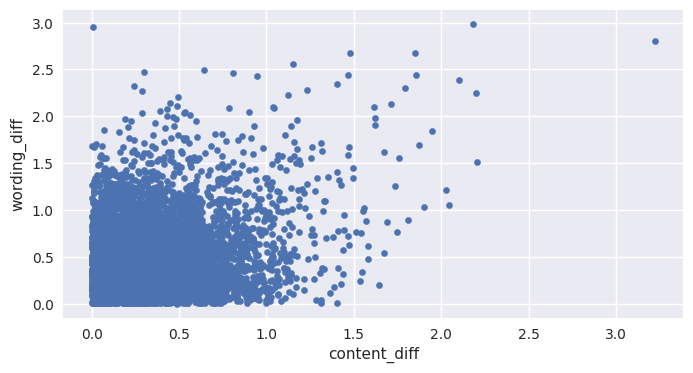

In [22]:
data.plot.scatter(x="content_diff", y="wording_diff", figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
dtype: object

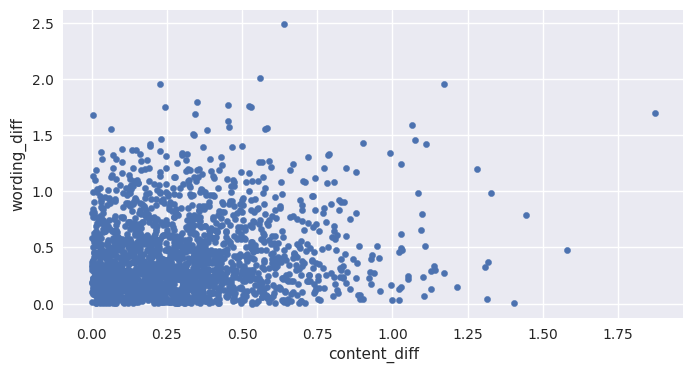

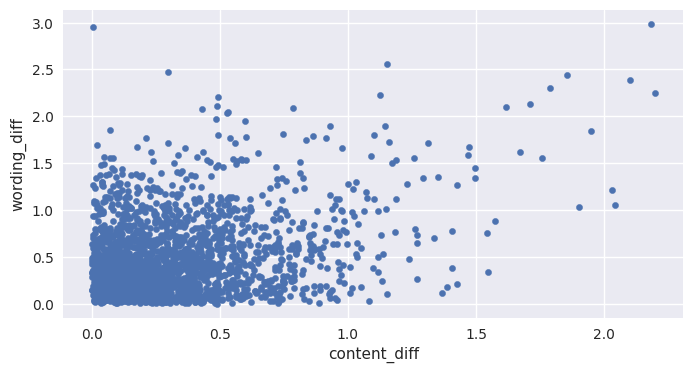

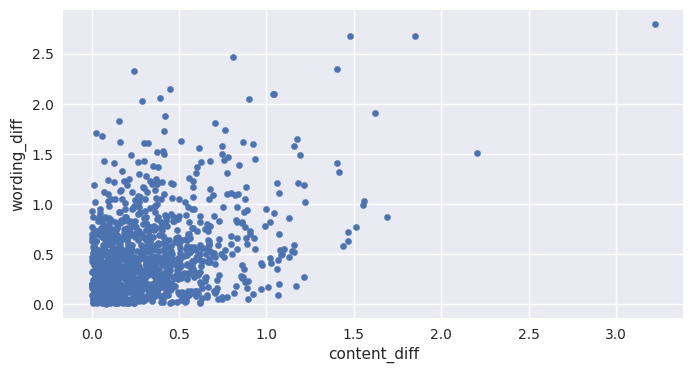

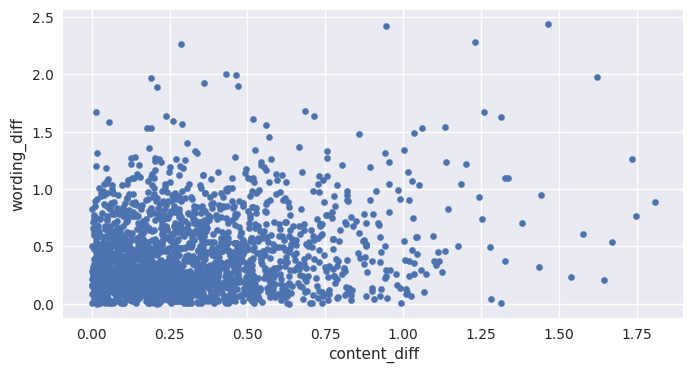

In [23]:
data.groupby("prompt_id").plot.scatter(x="content_diff", y="wording_diff", figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: content_diff, dtype: object

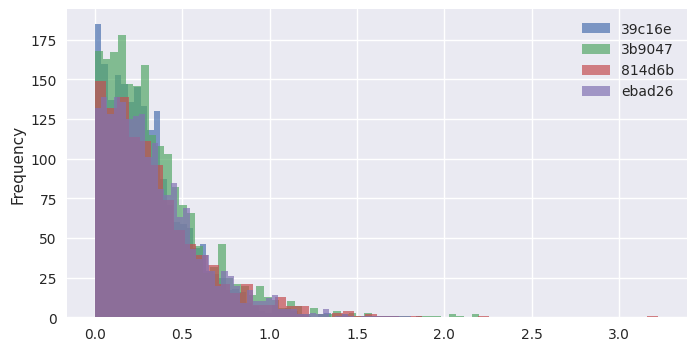

In [24]:
data.groupby("prompt_id")["content_diff"].plot.hist(bins=50, figsize=(8, 4), alpha=0.7, legend=True)

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: wording_diff, dtype: object

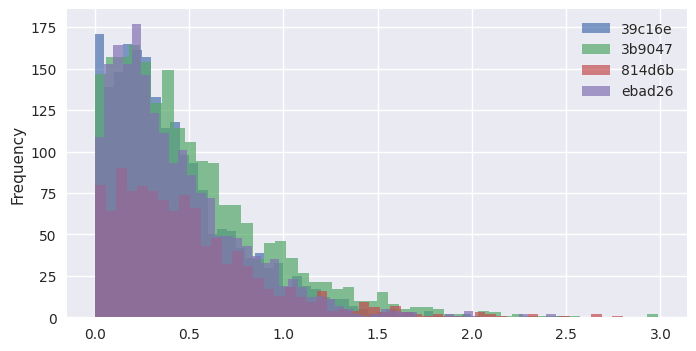

In [25]:
data.groupby("prompt_id")["wording_diff"].plot.hist(bins=50, figsize=(8, 4), alpha=0.7, legend=True)

## `3b9047` の誤差を詳細に見る

In [26]:
tmp = data.query("prompt_id == '3b9047'")

<Axes: xlabel='wording_diff'>

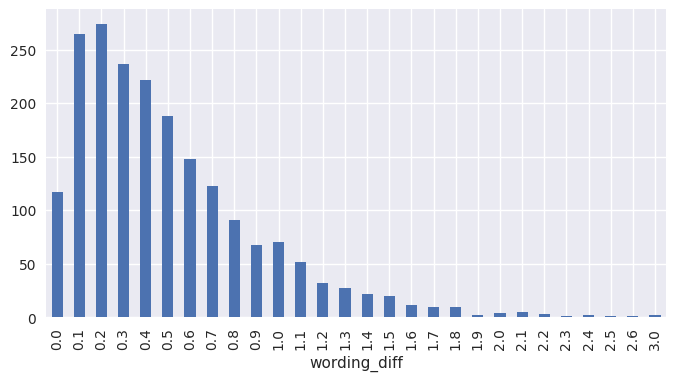

In [27]:
tmp["wording_diff"].round(1).value_counts().sort_index().plot.bar(figsize=(8, 4))

In [28]:
tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)
tmp.groupby("wording_diff_bin")[feature_names].mean()

/tmp/ipykernel_78856/860738255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)


,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count
wording_diff_bin,,,,,,,,
0.0,77.837607,7.974359,454.521368,11.512821,6.247863,0.367521,0.547009,0.000000
0.1,74.596226,7.928302,432.562264,10.671698,5.641509,0.335849,0.600000,0.041509
0.2,73.467153,7.959854,430.459854,10.912409,5.635036,0.277372,0.529197,0.043796
0.3,75.624473,7.966245,440.514768,10.928270,5.827004,0.253165,0.510549,0.012658
0.4,74.207207,7.941441,432.756757,11.049550,5.738739,0.288288,0.567568,0.045045
0.5,74.441489,7.952128,430.712766,10.898936,5.835106,0.345745,0.569149,0.031915
0.6,81.682432,7.972973,477.520270,12.486486,6.540541,0.418919,0.783784,0.020270
0.7,81.723577,7.943089,479.162602,12.414634,6.430894,0.333333,0.634146,0.048780
0.8,87.318681,7.989011,506.296703,12.989011,6.659341,0.252747,0.549451,0.032967


## `814d6b` の誤差を詳細に見る

<Axes: xlabel='wording_diff'>

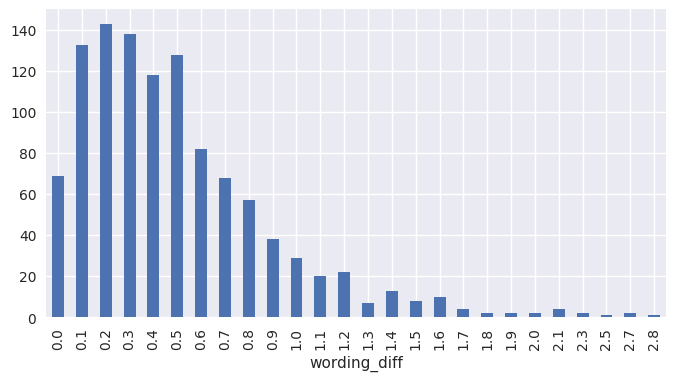

In [29]:
tmp = data.query("prompt_id == '814d6b'")

tmp["wording_diff"].round(1).value_counts().sort_index().plot.bar(figsize=(8, 4))

In [30]:
tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)
tmp.groupby("wording_diff_bin")[feature_names].mean()

/tmp/ipykernel_78856/860738255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)


,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count
wording_diff_bin,,,,,,,,
0.0,64.985507,7.927536,368.681159,6.681159,4.086957,0.130435,0.217391,0.000000
0.1,65.473684,7.932331,367.947368,6.466165,4.421053,0.120301,0.263158,0.052632
0.2,59.615385,7.888112,331.874126,6.006993,3.895105,0.083916,0.202797,0.006993
0.3,64.355072,7.876812,361.210145,6.362319,4.007246,0.094203,0.217391,0.043478
0.4,66.500000,7.932203,377.830508,6.652542,4.432203,0.127119,0.313559,0.016949
0.5,69.078125,7.914062,390.375000,7.000000,4.562500,0.148438,0.351562,0.046875
0.6,68.231707,7.926829,386.695122,6.963415,4.390244,0.195122,0.292683,0.000000
0.7,73.000000,7.926471,412.779412,7.147059,4.735294,0.176471,0.235294,0.014706
0.8,83.385965,7.964912,469.877193,8.105263,5.157895,0.210526,0.403509,0.087719


`word_count` が大きいほど誤差が大きいのが特徴的。

例外はある。前半に予測に寄与する単語が入ってるとかなのか？binごとのサンプルは少ないだろうから分散はそれなりにありそう。

他のprompt_idのも見てみる。

In [31]:
data.loc[:, "wording_diff_bin"] = data["wording_diff"].round(1)
data.groupby(["prompt_id", "wording_diff_bin"])[feature_names].mean()

word_count  word_overlap_count  text_length  \
prompt_id wording_diff_bin                                                
39c16e    0.0                60.748538            7.988304   341.157895   
          0.1                55.181185            7.982578   307.947735   
          0.2                56.641104            7.990798   316.374233   
          0.3                54.137457            7.969072   300.979381   
          0.4                64.136752            7.991453   360.910256   
          0.5                64.648936            7.994681   362.175532   
          0.6                63.856061            7.962121   356.454545   
          0.7                70.851485            8.000000   399.663366   
          0.8                74.531646            7.962025   420.746835   
          0.9                73.059701            7.985075   407.731343   
          1.0                76.452830            7.962264   431.905660   
          1.1                70.348837            8.000000   397.093023   
          1.2                73.586207            7.931034   409.931034   
          1.3                66.136364            8.000000   370.045455   
          1.4                71.090909            8.000000   380.272727   
          1.5               131.800000            8.000000   763.000000   
          1.6               120.500000            8.000000   708.833333   
          1.7               123.500000            8.000000   692.000000   
          1.8               125.500000            8.000000   735.250000   
          2.0               268.666667            8.000000  1543.666667   
          2.5               641.000000            8.000000  3711.000000   
3b9047    0.0                77.837607            7.974359   454.521368   
          0.1                74.596226            7.928302   432.562264   
          0.2                73.467153            7.959854   430.459854   
          0.3                75.624473            7.966245   440.514768   
          0.4                74.207207            7.941441   432.756757   
          0.5                74.441489            7.952128   430.712766   
          0.6                81.682432            7.972973   477.520270   
          0.7                81.723577            7.943089   479.162602   
          0.8                87.318681            7.989011   506.296703   
          0.9                90.367647            8.000000   529.029412   
          1.0                98.228571            7.971429   573.471429   
          1.1               120.269231            8.000000   718.173077   
          1.2               119.687500            8.000000   702.625000   
          1.3               114.481481            8.000000   683.592593   
          1.4               121.772727            8.000000   723.863636   
          1.5               148.800000            7.950000   891.500000   
          1.6               144.416667            8.000000   855.666667   
          1.7               151.100000            8.000000   911.900000   
          1.8               120.700000            8.000000   725.100000   
          1.9               109.000000            8.000000   648.000000   
          2.0               197.000000            8.000000  1157.500000   
          2.1               207.200000            8.000000  1263.400000   
          2.2               173.333333            8.000000  1053.000000   
          2.3               118.000000            8.000000   730.000000   
          2.4               190.500000            8.000000  1201.000000   
          2.5               202.000000            8.000000  1219.000000   
          2.6               170.000000            8.000000  1031.000000   
          3.0               298.000000            8.000000  1857.500000   
814d6b    0.0                64.985507            7.927536   368.681159   
          0.1                65.473684            7.932331   367.947368   
          0.2                59.615385            7.8

他のprompt_idも同様の傾向が見られる。

`wording` とある通り、実際には全文目を通してスコアをつけているから後半の部分が無視されている可能性が高い。


対策として、contentはprompt_text+summary text とし、wordingはsummary textのみとするのはどうだろうか。

`content` も見てみる。

In [32]:
data.loc[:, "content_diff_bin"] = data["content_diff"].round(1)
data.groupby(["prompt_id", "content_diff_bin"])[feature_names].mean()

word_count  word_overlap_count  text_length  \
prompt_id content_diff_bin                                                
39c16e    0.0                59.650862            7.991379   334.797414   
          0.1                58.488834            7.982630   327.483871   
          0.2                57.177249            7.984127   318.857143   
          0.3                55.872093            7.988372   311.177326   
          0.4                61.338776            7.987755   343.179592   
          0.5                70.815287            7.987261   399.165605   
          0.6                77.652542            7.966102   436.254237   
          0.7                68.605634            7.943662   384.338028   
          0.8                89.645833            7.979167   510.416667   
          0.9                93.350000            8.000000   531.050000   
          1.0                92.000000            7.928571   521.714286   
          1.1                99.866667            8.000000   562.000000   
          1.2               133.000000            7.666667   769.333333   
          1.3               145.200000            8.000000   820.600000   
          1.4               225.500000            8.000000  1315.000000   
          1.6                92.000000            8.000000   513.000000   
          1.9               200.000000            8.000000  1111.000000   
3b9047    0.0                82.666667            7.957672   482.402116   
          0.1                76.732323            7.969697   449.398990   
          0.2                70.896142            7.928783   407.762611   
          0.3                78.384615            7.974359   457.076923   
          0.4                73.337662            7.965368   427.160173   
          0.5                97.569061            7.955801   575.839779   
          0.6                90.457447            7.957447   531.223404   
          0.7               100.964286            7.952381   596.416667   
          0.8               124.215686            7.980392   733.392157   
          0.9                97.025000            7.975000   579.675000   
          1.0                93.387097            8.000000   555.129032   
          1.1               104.263158            8.000000   607.263158   
          1.2               150.888889            8.000000   910.888889   
          1.3               175.250000            8.000000  1057.625000   
          1.4               124.714286            8.000000   723.285714   
          1.5               121.833333            8.000000   734.333333   
          1.6               124.500000            8.000000   822.500000   
          1.7               168.500000            8.000000  1007.000000   
          1.8                94.000000            8.000000   590.000000   
          1.9               229.666667            8.000000  1326.666667   
          2.0               136.000000            8.000000   832.500000   
          2.1               163.000000            8.000000  1002.000000   
          2.2               259.000000            8.000000  1567.000000   
814d6b    0.0                61.413793            7.905172   344.448276   
          0.1                62.774648            7.920188   354.478873   
          0.2                68.375635            7.913706   384.751269   
          0.3                65.656051            7.891720   369.541401   
          0.4                76.496183            7.923664   434.251908   
          0.5                79.162500            7.950000   449.987500   
          0.6                81.606557            7.967213   462.180328   
          0.7                92.891304            7.934783   522.565217   
          0.8                80.333333            7.958333   458.625000   
          0.9                96.370370            8.000000   546.481481   
          1.0               112.500000            8.000000   647.750000   
          1.1               103.142857            7.9

debertaが観測できていない単語や単語ごとの特徴量をもっと加える方向性を探ってみる。

あとはprompt questionに対しての異なる表現でのうまい言い回しをしていたりすると評価が高いかもしれない。

## Feature idea

- 単語の長さの最大、平均、中央
- debertaのmax_lenを1024などの512以上の値にする